### 1. Cite 5 diferenças entre o AdaBoost e o GBM.

| AdaBoost                                                                             | GBM (Gradient Boosting Machine)                                                          |
| ------------------------------------------------------------------------------------ | ---------------------------------------------------------------------------------------- |
| 1. Usa pesos para ajustar amostras após cada iteração, focando em erros anteriores.  | 1. Usa gradiente do erro (função perda) para ajustar o modelo na próxima iteração.       |
| 2. Tradicionalmente, só funciona para classificação.                                 | 2. Funciona tanto para classificação quanto regressão.                                   |
| 3. Adiciona modelos sequencialmente, cada um tentando corrigir os erros do anterior. | 3. Também adiciona modelos sequencialmente, mas otimiza a função de perda por gradiente. |
| 4. Atualiza pesos das amostras para focar nos exemplos difíceis.                     | 4. Atualiza o modelo base ajustando o gradiente negativo da função perda.                |
| 5. Modelo base padrão costuma ser árvore de decisão rasa (stumps).                   | 5. Modelo base também são árvores, mas pode ser mais profundo e configurável.            |


Erro Quadrático Médio (MSE) no conjunto de teste: 1.61
Coeficiente de Determinação (R^2) no conjunto de teste: 0.94


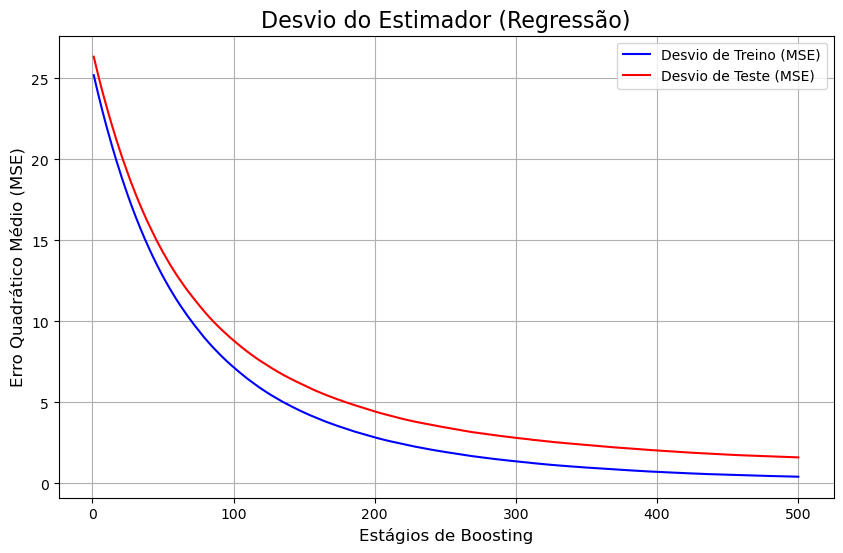

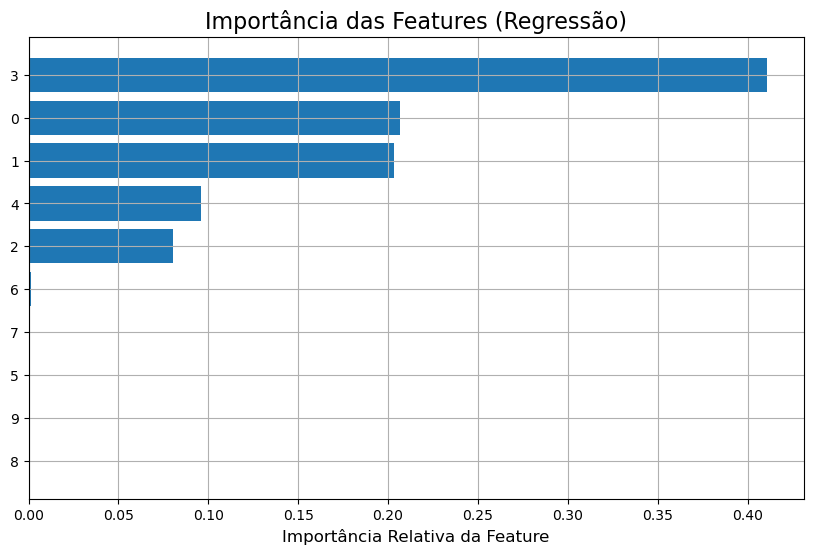

Acurácia no conjunto de teste: 0.94

Relatório de Classificação:
              precision    recall  f1-score   support

        -1.0       0.92      0.95      0.93      1746
         1.0       0.95      0.92      0.94      1854

    accuracy                           0.94      3600
   macro avg       0.94      0.94      0.94      3600
weighted avg       0.94      0.94      0.94      3600



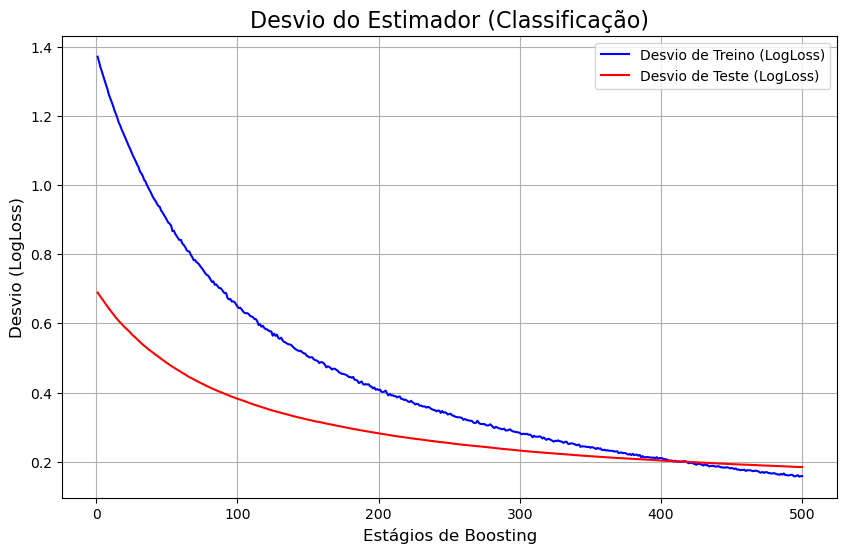

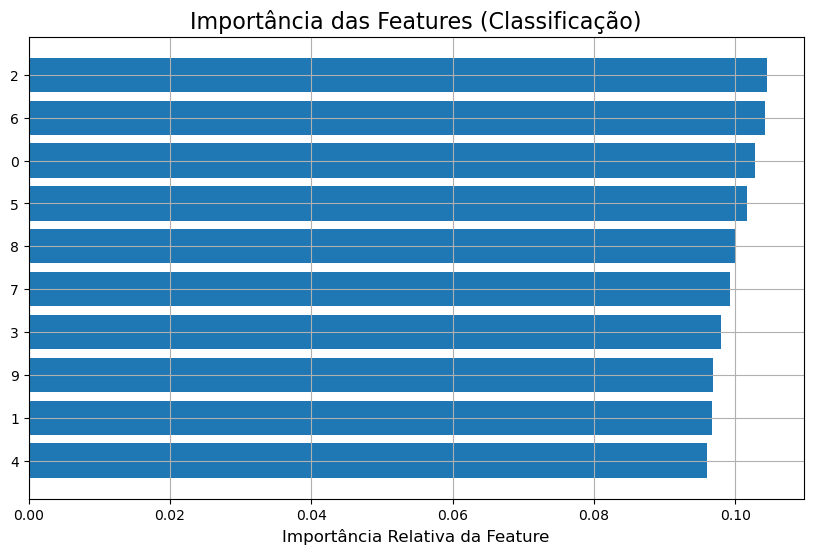


Iniciando GridSearch (isso pode levar alguns minutos)...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
GridSearch Concluído.

Melhores hyperparâmetros encontrados: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Melhor score (MSE negativo): -0.99

Erro Quadrático Médio (MSE) com melhores hyperparâmetros no teste: 0.70
Coeficiente de Determinação (R^2) com melhores hyperparâmetros no teste: 0.97


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, log_loss
from sklearn.datasets import make_friedman1, make_hastie_10_2

X_reg, y_reg = make_friedman1(n_samples=1000, n_features=10, random_state=0)

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=0
)

params_reg = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_leaf": 1,
    "learning_rate": 0.01,
    "loss": "squared_error",
    "random_state": 0 
}

reg_model = ensemble.GradientBoostingRegressor(**params_reg)
reg_model.fit(X_reg_train, y_reg_train)

y_reg_pred = reg_model.predict(X_reg_test)

mse_reg = mean_squared_error(y_reg_test, y_reg_pred)
r2_reg = r2_score(y_reg_test, y_reg_pred)
print(f"Erro Quadrático Médio (MSE) no conjunto de teste: {mse_reg:.2f}")
print(f"Coeficiente de Determinação (R^2) no conjunto de teste: {r2_reg:.2f}")

test_score_reg_plot = np.zeros((params_reg["n_estimators"],), dtype=np.float64)
for i, y_pred_stage in enumerate(reg_model.staged_predict(X_reg_test)):
    test_score_reg_plot[i] = mean_squared_error(y_reg_test, y_pred_stage)

fig_reg = plt.figure(figsize=(10, 6))
plt.subplot(1, 1, 1)
plt.title("Desvio do Estimador (Regressão)", fontsize=16)
plt.plot(
    np.arange(params_reg["n_estimators"]) + 1,
    reg_model.train_score_,
    "b-",
    label="Desvio de Treino (MSE)",
)
plt.plot(
    np.arange(params_reg["n_estimators"]) + 1,
    test_score_reg_plot,
    "r-",
    label="Desvio de Teste (MSE)",
)
plt.legend(loc="upper right")
plt.xlabel("Estágios de Boosting", fontsize=12)
plt.ylabel("Erro Quadrático Médio (MSE)", fontsize=12)
plt.grid(True)
plt.show()

feature_importance_reg = reg_model.feature_importances_
sorted_idx_reg = np.argsort(feature_importance_reg)
pos_reg = np.arange(sorted_idx_reg.shape[0]) + 0.5
fig_imp_reg = plt.figure(figsize=(10, 6))
plt.subplot(1, 1, 1)
plt.barh(pos_reg, feature_importance_reg[sorted_idx_reg], align="center")
plt.yticks(pos_reg, sorted_idx_reg)
plt.xlabel("Importância Relativa da Feature", fontsize=12)
plt.title("Importância das Features (Regressão)", fontsize=16)
plt.grid(True)
plt.show()

X_clf, y_clf = make_hastie_10_2(n_samples=12000, random_state=0)
X_clf = X_clf.astype(np.float32)

labels, y_clf = np.unique(y_clf, return_inverse=True)

X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.3, random_state=0
)

params_clf = {
    "n_estimators": 500,
    "max_depth": 5,
    "learning_rate": 0.05,
    "subsample": 0.7,
    "random_state": 0,
}

clf_model = ensemble.GradientBoostingClassifier(**params_clf)
clf_model.fit(X_clf_train, y_clf_train)

y_clf_pred = clf_model.predict(X_clf_test)

accuracy_clf = accuracy_score(y_clf_test, y_clf_pred)
print(f"Acurácia no conjunto de teste: {accuracy_clf:.2f}")

print("\nRelatório de Classificação:")
print(classification_report(y_clf_test, y_clf_pred, target_names=[str(label) for label in labels]))

test_deviance_clf_plot = np.zeros((params_clf["n_estimators"],), dtype=np.float64)
for i, y_pred_raw_stage in enumerate(clf_model.staged_decision_function(X_clf_test)):

    y_pred_proba_stage = 1 / (1 + np.exp(-y_pred_raw_stage))

    epsilon = 1e-15
    y_pred_proba_stage = np.clip(y_pred_proba_stage, epsilon, 1 - epsilon)
    test_deviance_clf_plot[i] = log_loss(y_clf_test, y_pred_proba_stage)

fig_clf = plt.figure(figsize=(10, 6))
plt.subplot(1, 1, 1)
plt.title("Desvio do Estimador (Classificação)", fontsize=16)
plt.plot(
    np.arange(params_clf["n_estimators"]) + 1,
    clf_model.train_score_,
    "b-",
    label="Desvio de Treino (LogLoss)",
)
plt.plot(
    np.arange(params_clf["n_estimators"]) + 1,
    test_deviance_clf_plot,
    "r-",
    label="Desvio de Teste (LogLoss)",
)
plt.legend(loc="upper right")
plt.xlabel("Estágios de Boosting", fontsize=12)
plt.ylabel("Desvio (LogLoss)", fontsize=12)
plt.grid(True)
plt.show()

feature_importance_clf = clf_model.feature_importances_
sorted_idx_clf = np.argsort(feature_importance_clf)
pos_clf = np.arange(sorted_idx_clf.shape[0]) + 0.5
fig_imp_clf = plt.figure(figsize=(10, 6))
plt.subplot(1, 1, 1)
plt.barh(pos_clf, feature_importance_clf[sorted_idx_clf], align="center")
plt.yticks(pos_clf, sorted_idx_clf)
plt.xlabel("Importância Relativa da Feature", fontsize=12)
plt.title("Importância das Features (Classificação)", fontsize=16)
plt.grid(True)
plt.show()

X_reg_gs, y_reg_gs = make_friedman1(n_samples=1000, n_features=10, random_state=0)
X_reg_train_gs, X_reg_test_gs, y_reg_train_gs, y_reg_test_gs = train_test_split(
    X_reg_gs, y_reg_gs, test_size=0.3, random_state=0
)

gbm_reg_gs = ensemble.GradientBoostingRegressor(random_state=0)

param_grid_gs = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1.0],
}

grid_search_reg_gs = GridSearchCV(
    estimator=gbm_reg_gs,
    param_grid=param_grid_gs,
    cv=5,  
    scoring="neg_mean_squared_error",  
    verbose=2,
    n_jobs=-1,
)

print("\nIniciando GridSearch (isso pode levar alguns minutos)...")
grid_search_reg_gs.fit(X_reg_train_gs, y_reg_train_gs)
print("GridSearch Concluído.")

print(f"\nMelhores hyperparâmetros encontrados: {grid_search_reg_gs.best_params_}")
print(f"Melhor score (MSE negativo): {grid_search_reg_gs.best_score_:.2f}")

best_reg_model_gs = grid_search_reg_gs.best_estimator_
y_reg_pred_best_gs = best_reg_model_gs.predict(X_reg_test_gs)

mse_reg_best_gs = mean_squared_error(y_reg_test_gs, y_reg_pred_best_gs)
r2_reg_best_gs = r2_score(y_reg_test_gs, y_reg_pred_best_gs)
print(f"\nErro Quadrático Médio (MSE) com melhores hyperparâmetros no teste: {mse_reg_best_gs:.2f}")
print(f"Coeficiente de Determinação (R^2) com melhores hyperparâmetros no teste: {r2_reg_best_gs:.2f}")


### 3. Cite 5 Hyperparametros importantes no GBM.

n_estimators: número de árvores no modelo.

learning_rate: taxa de aprendizado, controla o peso de cada árvore nova.

max_depth: profundidade máxima de cada árvore.

min_samples_split: número mínimo de amostras necessárias para dividir um nó.

subsample: fração de amostras usadas para treinar cada árvore (usado em GBM estocástico).

In [9]:

from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

X_reg, y_reg = make_friedman1(n_samples=1000, n_features=10, random_state=0)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=0
)

gbm_reg = ensemble.GradientBoostingRegressor(random_state=0)

param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1.0], 
}

grid_search_reg = GridSearchCV(
    estimator=gbm_reg,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="neg_mean_squared_error", 
    verbose=2,
    n_jobs=-1,
)

print("\nIniciando GridSearch (isso pode levar alguns minutos)...")
grid_search_reg.fit(X_reg_train, y_reg_train)
print("GridSearch Concluído.")

print(f"\nMelhores hyperparâmetros encontrados: {grid_search_reg.best_params_}")
print(f"Melhor score (MSE negativo): {grid_search_reg.best_score_:.2f}")

best_reg_model = grid_search_reg.best_estimator_
y_reg_pred_best = best_reg_model.predict(X_reg_test)

mse_reg_best = mean_squared_error(y_reg_test, y_reg_pred_best)
r2_reg_best = r2_score(y_reg_test, y_reg_pred_best)
print(f"\nErro Quadrático Médio (MSE) com melhores hyperparâmetros no teste: {mse_reg_best:.2f}")
print(f"Coeficiente de Determinação (R^2) com melhores hyperparâmetros no teste: {r2_reg_best:.2f}")



Iniciando GridSearch (isso pode levar alguns minutos)...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
GridSearch Concluído.

Melhores hyperparâmetros encontrados: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Melhor score (MSE negativo): -0.99

Erro Quadrático Médio (MSE) com melhores hyperparâmetros no teste: 0.70
Coeficiente de Determinação (R^2) com melhores hyperparâmetros no teste: 0.97


### 5. Acessando o artigo do Jerome Friedman (Stochastic) e pensando no nome dado ao Stochastic GBM, qual é a maior diferença entre os dois algoritmos?

O Stochastic GBM é uma variação do GBM que utiliza subamostragem aleatória (sem reposição) das amostras para treinar cada árvore, o que reduz a variância e pode melhorar a generalização.

Enquanto o GBM padrão usa todo o conjunto de dados para construir cada árvore, o Stochastic GBM escolhe uma amostra aleatória em cada etapa, tornando o processo mais "estocástico" e robusto contra overfitting.